# PEC representation of Rigetti gates using Mitiq
This was originally intended to be a part of the `process_gst.ipynb` notebook, but it seems as though Mitiq and pyGSTi rely on competing versions of Numpy. My solution was to pickle the resulting operators and unpickle them in this notebook. Ideally I would like to get both running together.

I ran a pyGSTi gate set tomography of $X(-\frac{\pi}{2})$ and $Z(-\frac{\pi}{2})$ on the Rigetti hardware. PyGSTi spits out transfer matrices, which can be converted to superoperator representations using `forest.benchmarking.operator_tools.superoperator_transformations.pauli_liouville2superop`. These were then imported here. First, I generated a noisy basis of operators by taking arbitrary products of noisy operators in the set. Then, I used the `mitiq.pec.representations.optimal.find_optimal_representation` method to generate an optimal representation of the nosiy gate. I compared the complexity of the distribution and the overhead for different gate depths. 

There are several improvements I would like to make going forward. pyGSTi uses pre-computed lists of feducials, which are required to be informationally complete and maximally orthogonal, and a set of germs to be repeated at different depths, which they term 'amplificationally complete'. Because I still don't understand how these are constructed, I am using the default modelpacks. The modelpack I chose did not include idling. In the future I would like to repeat this and see how much the inclusion of the idle gate affects the QPD representation. In addition, I would like to know how accurate this model is for different qubits. I would like to run gate set tomographies on different qubits to see how they compare, and test if the same QPD representations are approximately correct for all of the qubits. Lastly, there is something weird going on with the interpretation of $RX(\theta)$ as $\exp(i\frac{\theta}{2})$ or $\exp(-i\frac{\theta}{2})$. I don't know whether this is coming from the mitiq, pyGSTi, pyQuil, or Qiskit representation. The results look correct but at one point I had to drop a sign without knowing why.

In [31]:
'''
-    NoisyOperations store ideal representation as a generalized PROGRAM object (here using qiskit circuits)
         along with a SuperOperator matrix representing the error channel.
-    NoisyBasis stores a list of NoisyOperations and provides several sampling tools
     find_optimal_representation is a routine that automatically finds a QPD representation of the ideal gate 
     with the smallest possible negative overhead.
'''
from mitiq.pec import NoisyOperation, NoisyBasis 
from mitiq.pec.representations.optimal import find_optimal_representation

#Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import SuperOp, Kraus, Operator
from qiskit.circuit.library import RXGate, RZGate, XGate, YGate, ZGate, IGate

#Helper libraries
import pickle
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

#make numpy matrices easier to read
np.set_printoptions(precision=3, suppress=True)

## Import superoperators
These were found by running a pyGSTi standard gate set tomography using the `smq1Q_XZ` modelpack. I could not get mitiq running with the same version of numpy as pyGSTi, so these are pickled in `process_gst.ipynb` and imported here.

In [32]:
fname = "XZ.superop"
with open(fname,"rb") as f: #Load pickled data
    superops = pickle.load(f)

superops = [SuperOp(s) for s in superops] #initialize superoperators

#Create a list of ideal gates as labels for the noisy ones
ideal_gates = [RXGate(-np.pi/2), RZGate(-np.pi/2), IGate()]

## Create noisy basis
From the $M$ gates in the gateset, there are $M^n$ gates in the basis with length $n$. I don't think the basis needs to be orthogonal, so the span theoretically will increase with the depths $n$ that are considered in the set. The following cell generates such a spanning set of the permissible operations by listing out all the words from elements in the gate set with a length $n$ for all $n \leq N$. Then it uses these along with the corresponding ideal circuits to construct `NoisyOperation` elements, and combine these into a `NoisyBasis` (which again I think is just ideally a spanning set).

In [33]:
#This method generates all words of a certain length from a set of superoperators, 
#and returns a list of NoisyOperations
def get_gate_sequences(n):
    NoisyOperations = []

    for string in product(zip(superops,ideal_gates), repeat=n): #combine the noisy and ideal ops and iterate through words
        qc = QuantumCircuit(1)
        superop = SuperOp(np.identity(4)) #start at the identity op

        for (noisy_op, ideal_op) in string: #iterate through all the pairs in string
            qc.append(ideal_op,[0]) #add the ideal op to circuit
            superop = superop.compose(noisy_op) #compose the noisy op for total channel

        NoisyOperations.append(NoisyOperation(qc, superop.data)) #Instatiate NoisyOperation and add to array
    
    return NoisyOperations.copy()

NoisyOperations = []
N = 3

for i in range(N): #do this for all n <= N
    NoisyOperations = np.concatenate((NoisyOperations, get_gate_sequences(i+1)))

#combine into basis object
noisy_basis = NoisyBasis(*NoisyOperations)

## Generate PEC representation
If the spanning set is big enough, there may be many combinations of gates that form a QPD representation of the ideal gate within the desired tolerance level. Thus, the challenge is to find the representation
$$
\mathcal{U}_{ideal} = \sum_{\alpha}\eta_\alpha \mathcal{O}_\alpha
$$
Where $\mathcal{O}_\alpha$ are noisy operations and
$$
\gamma = \sum_{\alpha}\vert \eta_\alpha \vert
$$
is minimized. Mitiq provides a method to do this automatically. The `find_optimal_representation` method returns an optimal representation of a `PROGRAM` object, which can be a Circ, Quil, or Qiskit circuit object, given a noisy basis, and a desired tolerance level. In practice, I found that the overhead is highly sensitive to the tolerance level. A nearly perfect representation is accessible, but with an intractible overhead.

As is expected, the noisy gate $RX(-\frac{\pi}{2})$ has the largest coefficient because it closely approximates the true gate, with other corrective terms.

In [34]:
#Optimal circuit to represent
optimal_circuit = QuantumCircuit(1)
optimal_circuit.append(RXGate(-np.pi/2), [0])

#get optimal representation in terms of noisy gates
optimal_rep = find_optimal_representation(optimal_circuit, noisy_basis, tol=.01)
print(optimal_rep)
print("Overhead: ", optimal_rep.norm) #hopefully close to 1

q_0: ───Rx(-0.5π)─── = -0.004*(q_0: ───Rx(-0.5π)───Rz(-0.5π)───Rz(-0.5π)───)-0.001*(q_0: ───Rx(-0.5π)───Rx(-0.5π)───Rx(-0.5π)───)+0.015*(q_0: ───Rx(-0.5π)───Rz(-0.5π)───)+0.992*(q_0: ───Rx(-0.5π)───)+0.007*(q_0: ───Rx(-0.5π)───Rz(-0.5π)───Rx(-0.5π)───)-0.002*(q_0: ───Rz(-0.5π)───Rz(-0.5π)───)+0.008*(q_0: ───Rz(-0.5π)───Rx(-0.5π)───)-0.006*(q_0: ───Rz(-0.5π)───Rz(-0.5π)───Rz(-0.5π)───)+0.002*(q_0: ───Rz(-0.5π)───)
Overhead:  1.037184079299902


The approximated superoperator is very close to the desired gate

In [35]:
matrices = [m.channel_matrix for m in optimal_rep.noisy_operations]
mat = sum(m*coeff for (m,coeff) in zip(matrices, optimal_rep.coeffs))
print("Approximated superoperator")
print(mat)
print('------------------------------')
print("Ideal superoperator")
ideal_mat = SuperOp(RXGate(np.pi/2)).data #It clearly matches RX(pi/2), but I don't know why
print(ideal_mat)

Approximated superoperator
[[ 0.507+0.j    -0.007-0.49j  -0.007+0.49j   0.501-0.j   ]
 [-0.003-0.492j  0.499-0.01j   0.49 +0.006j  0.01 +0.49j ]
 [-0.003+0.492j  0.49 -0.006j  0.499+0.01j   0.01 -0.49j ]
 [ 0.504-0.j     0.007+0.49j   0.007-0.49j   0.51 -0.j   ]]
------------------------------
Ideal superoperator
[[0.5+0.j  0. -0.5j 0. +0.5j 0.5+0.j ]
 [0. -0.5j 0.5+0.j  0.5+0.j  0. +0.5j]
 [0. +0.5j 0.5+0.j  0.5+0.j  0. -0.5j]
 [0.5+0.j  0. +0.5j 0. -0.5j 0.5+0.j ]]


## Test effect of different parameters
The relevant independent parameters are the max depth $N$ of the noisy basis and the tolerance of the fit. These might effect the final estimate in two ways: the overhead can get larger or closer to one, and the probability distribution may become more or less complicated to sample.

In [36]:
#generate basis of circuits with depth N and below
def generate_noisy_basis(N):
    NoisyOperations = []
    for i in range(N): #do this for all n <= N
        NoisyOperations = np.concatenate((NoisyOperations, get_gate_sequences(i+1)))
    #combine into basis object
    return NoisyBasis(*NoisyOperations)

#frobenius distance between two matrices
def frobenius_dist(op1, op2):
    mat = op1-op2
    return (np.sqrt(np.trace(np.dot(mat,np.conjugate(np.transpose(mat)))))).real

In [53]:
#lengths of these sets become large
max_depths = [5] #Procedure fails for 2<=N<=6
noisy_bases = [generate_noisy_basis(N) for N in max_depths]

These next two cells compare the complexity of the distribution, the sampling overhead, and the distance to the ideal matrix. When looking at the complexity of the resulting probability distribution, I filtered out the coefficients less that $1\times 10^{-7}$ because it seemed reasonable to discard a result that would only be found once in 100,000 shots.

In [56]:
optimal_reps = [find_optimal_representation(optimal_circuit, noisy_basis_N, tol=1e-5) for noisy_basis_N in noisy_bases] #fails for 2<=N<=5
print("Tolerance 1e-5:")
for optimal_rep in optimal_reps:
    channel_ops = [op.channel_matrix for op in optimal_rep.noisy_operations]
    channel = sum(op*coeff for (op,coeff) in zip(channel_ops, optimal_rep.coeffs))
    print("QPD with",
                    len([coeff for coeff in optimal_rep.coeffs if coeff > 1e-7]),
                    "operators and overhead",
                    optimal_rep.norm,
                    "and distance to ideal matrix",
                    frobenius_dist(channel, ideal_mat))

Tolerance 1e-5:
QPD with 34 operators and overhead 1.7338230851671923 and distance to ideal matrix 4.957837202478995e-05


In [86]:
import array_to_latex as a2l
a2l.to_ltx(channel, frmt = '{:6.7f}', arraytype = 'array')

\begin{array}
  0.4999900 + 0.0000000j &  0.0000099 + -0.4999900j &  0.0000099 + 0.4999900j &  0.4999900 + 0.0000000j\\
  0.0000100 + -0.5000059j &  0.4999900 + -0.0000092j &  0.4999900 + 0.0000090j &  0.0000100 + 0.4999941j\\
  0.0000100 + 0.5000059j &  0.4999900 + -0.0000090j &  0.4999900 + 0.0000092j &  0.0000100 + -0.4999941j\\
  0.5000100 + -0.0000000j & -0.0000099 + 0.4999900j & -0.0000099 + -0.4999900j &  0.5000100 + -0.0000000j
\end{array}


In [87]:
a2l.to_ltx(channel)

\begin{bmatrix}
  0.50 + 0.00j &  0.00 + -0.50j &  0.00 + 0.50j &  0.50 + 0.00j\\
  0.00 + -0.50j &  0.50 + -0.00j &  0.50 + 0.00j &  0.00 + 0.50j\\
  0.00 + 0.50j &  0.50 + -0.00j &  0.50 + 0.00j &  0.00 + -0.50j\\
  0.50 + -0.00j & -0.00 + 0.50j & -0.00 + -0.50j &  0.50 + -0.00j
\end{bmatrix}


In [76]:
np.set_printoptions(precision = 7, suppress= True)
ideal_mat

array([[0.5+0.j , 0. -0.5j, 0. +0.5j, 0.5+0.j ],
       [0. -0.5j, 0.5+0.j , 0.5+0.j , 0. +0.5j],
       [0. +0.5j, 0.5+0.j , 0.5+0.j , 0. -0.5j],
       [0.5+0.j , 0. +0.5j, 0. -0.5j, 0.5+0.j ]])

In [585]:
optimal_reps = [find_optimal_representation(optimal_circuit, noisy_basis_N, tol=.01) for noisy_basis_N in noisy_bases] #fails for 2<=N<=5
print("Tolerance .01:")
for optimal_rep in optimal_reps:
    channel_ops = [op.channel_matrix for op in optimal_rep.noisy_operations]
    channel = sum(op*coeff for (op,coeff) in zip(channel_ops, optimal_rep.coeffs))
    print("QPD with",
                    len([coeff for coeff in optimal_rep.coeffs if coeff > 1e-7]),
                    "operators and overhead",
                    optimal_rep.norm,
                    "and distance to ideal matrix",
                    frobenius_dist(channel, ideal_mat))

Tolerance .01:
QPD with 7 operators and overhead 1.0339647618960912 and distance to ideal matrix 0.0434106268407838
QPD with 16 operators and overhead 1.0580912023823537 and distance to ideal matrix 0.046535634799173754
QPD with 29 operators and overhead 1.0564030091714847 and distance to ideal matrix 0.04482870178549561


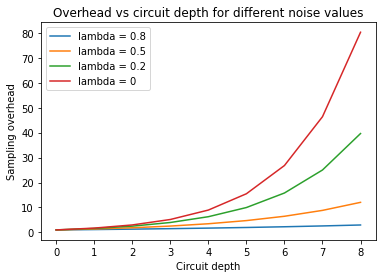

In [111]:
ax = np.arange(9)
gamma = 1.73
lmbdas = [.8,.5,.2,0]
for lmbda in lmbdas:
    plt.plot(ax, [(gamma-lmbda*(gamma-1))**n for n in ax])

plt.title("Overhead vs circuit depth for different noise values")
plt.xlabel("Circuit depth")
plt.ylabel("Sampling overhead")
plt.legend(["lambda = " + str(lmbda) for lmbda in lmbdas])

Text(0, 0.5, 'Overhead')

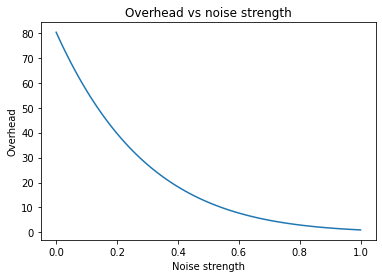

In [112]:
xax = np.linspace(0,1, 100)
plt.plot(xax, [(gamma-lmbda*(gamma-1))**8 for lmbda in xax])
plt.title("Overhead vs noise strength")
plt.xlabel("Noise strength")
plt.ylabel("Overhead")

## Analysis
Other than the weird sign disagreement in the operator which I am still looking into, the results mostly behave as expected. One surprising behavior is that the protocol fails when the `NoisyBasis` has too many elements. Since each element can only increase the span, I expected that the fit would get better and better. I suspect that the protocol is ideal for an actual basis, that is an orthogonal spanning set, which is therefore also minimal. The trend in the sampling overhead was different for the different tolerance levels. At a low tolerance, the overhead actually grew with the addition of more elements, with no benefit to the precision. However at very low tolerances, the overhead improved significantly with increased number of basis elements. 

I wonder in the future how to choose the best basis possible for this fit, and whether it might be related to the best choice of germs from pyGSTi. If so, then they could be imported to generate these lists. I think these results point generally to a choice of a basis with more redundancy over less, but the process should also be guided in some way to optimize the overhead and complexity with respect to the tolerance and basis depth.